# Summary and Background


## High-Level Summary

This document provides a summary tutorial for modelling human behavioural data. Much of my approach is guided by Wilson and Collins (2019).

I'll go through some of the steps for how to validate models in a bandit task and how to fit models to human data. Here I've focused on understanding how people explore (i.e., what strategy/policy they are using to explore within a bandit task).

The end goal here is to do three things:
1. Figure out how to validate a series of models on a specific task

  A. Test that the models can produce reasonable learning in the task in an ideal case
  
  B. Conduct parameter recovery: can we recover the best fit parameters of the models when we know the ground truth

  C. Conduct model recovery: can the models be distinguished when we simulate data from them and fit that data to each model

2. Determine how people are exploring (what exploration strategy they're using). We'll do this by taking models inspired by computational RL and fitting them to human choice data by minimizing the negative log likelihood.
2. When we are fitting the models to the human choice data, we'll want to estimate some best fit parameters for each person. These parameters should represent some latent cognitive process that we think is involved in exploration. For example, learning rate (step size in comp RL) is impossible to observe directly in people. But we can estimate a persons learning rate by fitting a model to their data and estimating the learning rate parameter.

## Exploration in the Literature

Within the literature there is dichotomy in exploration strategies:

1. **Random Exploration**: involves exploring another option randomly without considering additional information

    A. Can think of this as just “testing things out”
    
2. **Directed Exploration**: involves exploring options that the person wants to  gain specific information about

    A. Can think of this as “exploration to accomplish a specific goal” - common version is exploration to reduce uncertainty

People are thought to use the two strategies consistently within bandit-style learning tasks (Wilson et al., 2014). That is, most people are "hybrid" explorers.


###  Random Exploration

Random exploration can occur in a number of differerent ways. Two commons ones are "value-free random" and "probabalistic random"

1. **Value-free random**: when someone explores they choose another options completely randomly (eGreedy)
2. **Probabalistic random**: when someone explores, they tend to choose to explore options that are higher value (Softmax)



## Glossary
AIC = Akaike Information Criterion - measure of quality of model fit

BIC = Bayesian Information Criterion - measure of quality of model fit


# Models Used



## Learning Rule

**Value Update Equation**
$$
    q_{(t+1)}(a)= q_t(a)+ \alpha * \delta_t  \hspace{4cm} (1)
$$

Where $\alpha$ is the learning rate, $\delta$ is the prediction error, and q is the previous value

**Prediction Error**
$$
\delta_t = r_t - q_t(a)   \hspace{6.3cm}  (2)
$$

Where r is the reward obtained on that trial


## Choice Rules (i.e., how people make choices and explore)

We'll be using 3 models adapted from computational reinforcement learning to understand how people explore in a bandit task. The data will be from a four arm non-stationary bandit task.


**eGreedy**

This form of action selection is **value-free exploration**. Usually selects highest value options, but then explore randomly per the epsilon parameter ($\epsilon$):

$$
\begin{equation}
P_t(a_i) =
\begin{cases}
    1 - ε & \text{if argmax}(q_t)~~ \\
    ε \div 3 & \text{ otherwise}
\end{cases}
\end{equation} \hspace{2.1cm} (3)
$$

**Softmax**

This form of action selection is **probabalistic random exploration**. Usually selects highest value options, but then explores other options in decreasing value per the inverse temperature parameter ($\tau$):

$$
\begin{equation}
P_t(a_i) =
    \frac{exp (\tau*q_{t,i})}{\sum exp(\tau*q_{t,i})}
\end{equation} \hspace{4.3cm} (4)
$$

**Softmax-UCB**

This form of action selection is a **hybrid strategy** as it combines probabalistic random exploration with directed exploration (here operationalized as uncertainty reduction). Adds how uncertain people are about different options (based on the last time they selected each option) to the q-value estimate

$$
\begin{equation}
P_t(a_i) =
    \frac{exp (\tau*(q_{t,i}+B_{t,i})}{\sum exp(\tau*(q_{t,i}+B_{t,i}))}
\end{equation} \hspace{2.7cm} (5)
$$

where

$$
\begin{equation}
B_{t,i} = B_0[t - T_i]
\end{equation} \hspace{6.3cm} (6)
$$

$t$ = the current trial, $T_i$ is the last trial the option was selected, and $B_0$ is the information bonus term

### Parameter Fitting
Note that from each model for each person, we'll be trying to estimate a set of best-fit parameters from a set of choice and reward data from a bandit task.

1. eGreedy:
$$ \text{learning rate } (\alpha)  \text{ - how quickly model/person updates their q values} $$
$$ \text{epsilon } (\epsilon) \text{ - controls how often model/person explores}  $$

2. Softmax:

$$ \text{learning rate } (\alpha)  \text{ - how quickly model/person updates their q values} $$
$$ \text{inverse temperature } (\tau) \text{ - controls how often model/person explores}  $$

3. Softmax-UCB:

$$ \text{learning rate } (\alpha)  \text{ - how quickly model/person updates their q values} $$
$$ \text{inverse temperature } (\tau) \text{ - controls how often model/person explores}  $$
$$ \text{info bonus } (\text B_0) \text{ - how much the model/person incorporates uncertainty when making choices}  $$



# Packages/Variables to Load
Below are just the packages and variables we need to load/initialize

In [ ]:
# %% Environment Set up
# Packages
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import minimize
import seaborn as sns
import pandas as pd

# Set Seed for reproducibility
#random.seed(100)

# Variables
numTrials = 300
numArms = 4
trial = np.linspace(1, numTrials, numTrials) # needed for plotting
qInit = 1e-5 # initial qValues
numSim = 30 # the number of agents we'll fit
numModels = 3
taskParam = [numTrials, numArms]
numParam = 7 # total number of parameters across the three models
numFit = 5 # number attempts of fitting procedure (for negative log likelihood)


# Load Data

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving AIC_ModRec.csv to AIC_ModRec.csv
Saving BIC_ModRec.csv to BIC_ModRec.csv
Saving fullData2.csv to fullData2.csv
Saving ParameterRecovery.csv to ParameterRecovery.csv


# Functions to Load

### General Purpose Functions

In [ ]:
def dawGenerate(arms,Trials):

    """
    Generates a non-stationary bandit environment
    Code adapted from the task used in Daw et al., 2006

    """

    #Parameters Taken from Daw Paper
    decayParam = 0.9836;
    decayCen = 50;
    diffNoiseSD = 2.8;
    payoutSD = 2;

    #Create Blank Arrays
    payouts = np.zeros(shape=[Trials, arms])
    actualPayouts = np.zeros(shape=[Trials, arms])

    #Initialize Reward Value
    payouts[0, :] = 100*np.random.rand(4)

    #Compute Mean Payouts

    #Start at trial 2
    for trialCount in range(1,Trials):

       payouts[trialCount, :] = decayParam*payouts[trialCount-1, :] + (1-decayParam)*decayCen + diffNoiseSD * np.random.normal(size=arms);

    #Constrain Mean Payouts
    payouts[payouts < 1] = 1
    payouts[payouts > 100] = 100

    #Compute Actual Payouts
    noiseValue = payoutSD * np.random.normal(size=[Trials, arms])

    #Round Values
    actualPayouts = np.round(payouts+noiseValue)

    #Constain actual Payouts
    actualPayouts[actualPayouts < 1] = 1
    actualPayouts[actualPayouts > 100] = 100

    return(actualPayouts)

def paramCreate(numNeed):

    """
    Generates Random parameter values for each of the models.
    All that is needed to specify is the number of instances
    of the random parameters required
    """

    paraCreate = np.zeros(shape=[numNeed, 7])

    # eGreedy
    paraCreate[:, 0] = np.random.beta(1.1, 1.1, size=numNeed) # EG - LR
    paraCreate[:, 1] = np.random.beta(1.1, 1.1, size=numNeed)  # EG - Eps

    # Softmax
    paraCreate[:, 2] = np.random.beta(1.1, 1.1, size=numNeed)  # Rand - LR
    paraCreate[:, 3] = np.random.uniform(1, 30, size=numNeed)  # SM - Temp

    # Sofmtax Explore
    paraCreate[:, 4] = np.random.beta(1.1, 1.1, size=numNeed) # SMUCB - LR
    paraCreate[:, 5] = np.random.uniform(1, 30, size=numNeed)  # SMUCB - Temp
    paraCreate[:, 6] = np.random.gamma(1.1, 1.1, size=numNeed) # SMUCB - uncertainty

    return paraCreate


## Action Selection Functions

Throughout, we'll rely on the following action selection scripts. These scripts are used to simulate performance within the non-stationary bandit task (although of course they can be modified to simulate many other tasks). Each action selection function simply make choices based on the feedback it recieves per it's selection policy (so Softmax makes choices per the Softmax max rule based on some input temperature parameter and learning rate parameter).

For each of the three model functions, these functions take as input:
1. The parameter values for the model (e.g., a temperature and learning rate parameters)
2. The reward distribution of the task (basically the info on the task being performed)
3. The number of trials and arms (trialParam)
4. The initial q values

Each function outputs:
1. The Choices the model made
2. The Rewards the model obtained
3. The prediction error of the model on each trial

In [ ]:
# eGreedy Model - Random value free
def AS_EG(parameters,
            rewardVal,
            trialParam,
            startVal):

    # Task Param
    numTrials = int(trialParam[0])
    numArms = int(trialParam[1])

    #Initialize Parameters
    learningRate = parameters[0]
    expParam = parameters[1]

    # Set up Arrays
    selectionMat = np.zeros(shape = [numTrials])
    rewArray = np.zeros(shape = [numTrials])
    predErrorArray = np.zeros(shape = [numTrials])

    #Initialize Q Values
    qValue = np.zeros(shape=numArms) + startVal

    # Loop around trials
    for trial in range(numTrials):

        if np.random.random() < expParam:

            #Choose Another Option
            selection = int(np.random.randint(len(qValue)))

        else:

            #Current Action - Choose Greedy Option
            selection = np.random.choice(np.flatnonzero(qValue == qValue.max()))

        # Compute Reward
        reward = rewardVal[trial, selection] / 100

        # Compute Prediction Error
        predError = reward - qValue[selection]

        # Update QValue
        qValue[selection] = qValue[selection] + learningRate * predError

        #Update Arrays
        selectionMat[trial] = selection
        rewArray[trial] = reward * 100
        predErrorArray[trial] = predError

    return selectionMat, rewArray, predErrorArray


# Softmax Model - Random probabalistic
def AS_SM(parameters,
            rewardVal,
            trialParam,
            startVal):

    # Task Param
    numTrials = int(trialParam[0])
    numArms = int(trialParam[1])

    # Assign Parameters
    learningRate = parameters[0]
    temperature = parameters[1]

    # Set up Arrays
    selectionMat = np.zeros(shape = [numTrials])
    rewArray = np.zeros(shape = [numTrials])
    predErrorArray = np.zeros(shape = [numTrials])

    # Initialize Q Values
    qValue = np.zeros(shape=numArms) +  startVal

    # Intialize SM Result
    softmaxResult = np.zeros(shape=numArms)

    for trial in range(numTrials):

        selection = []
        reward = []

        # Compute Softmax values
        num = np.exp(np.multiply(qValue,temperature))

        denom = sum(np.exp(np.multiply(qValue,temperature)))

        # Find softmax result
        softmaxResult = num/denom

        # Assign Values to softmax options
        softmaxOptions = np.cumsum(softmaxResult) > np.random.rand()

        # Find arm choice
        selection = np.argmax(softmaxOptions)

        # Compute Reward
        reward = rewardVal[trial, selection] / 100

        # Compute Prediction Error
        predError = reward - qValue[selection]

        # Update QValue
        qValue[selection] = qValue[selection] + learningRate * predError

        # Update Arrays
        selectionMat[trial] = selection
        rewArray[trial] = reward * 100
        predErrorArray[trial] = predError

    return selectionMat, rewArray, predErrorArray


# Hybrid Model - Directed and Random
def AS_SMUCB(parameters,
            rewardVal,
            trialParam,
            startVal):

    # Task Param
    numTrials = int(trialParam[0])
    numArms = int(trialParam[1])

    learningRate = parameters[0]
    temperature = parameters[1]
    uncertParam = parameters[2]

    # Set up Arrays
    selectionMat = np.zeros(shape = [numTrials])
    rewArray = np.zeros(shape = [numTrials])
    predErrorArray = np.zeros(shape = [numTrials])

    # Initialize Q Values
    qValue = np.zeros(shape=numArms) + startVal

    # Initialize Uncertainty
    uncert = np.zeros(shape=numArms)+ 1

    # Needed so trial one isn't 0 in the SM equation
    n = 1

    # Intialize SM Result
    softmaxResult = np.zeros(shape=numArms)

    for trial in range(numTrials):

        selection = []
        reward = []

        # Version from S&K 2015
        lastCount = np.zeros(shape=numArms)
        for cTc in range(numArms):
            x = np.array(np.where(selectionMat[0:trial] == cTc))
            if x.size == 0:
                lastCount[cTc] = 0
            else:
                lastCount[cTc] = np.amax(x)
        uncert = (uncertParam * (n - lastCount)) / 100

        num = np.exp(np.multiply(qValue + uncert, temperature))

        denom = sum(np.exp(np.multiply(qValue + uncert, temperature)));

        # Find softmax result
        softmaxResult = num/denom

        # Find cumulative sum
        softmaxOptions = np.cumsum(softmaxResult) > np.random.rand()

        # Make Selection
        selection = np.argmax(softmaxOptions)

        # Update N
        n += 1

        #Compute Reward
        reward = rewardVal[trial, selection] / 100

        #Compute Prediction Error
        predError = reward - qValue[selection]

        #Update Reward - Non Stationary
        qValue[selection] = qValue[selection] + learningRate * predError

        #Update Arrays
        selectionMat[trial] = selection
        rewArray[trial] = reward * 100
        predErrorArray[trial] = predError

    return selectionMat, rewArray, predErrorArray

## Likelihood Functions

We'll also rely on the following negative log likelihood scripts. These scripts are used to calculate the best fitting parameters that minimize the negative log likelihood based on a set of observations. We will use these scripts to estimate best-fit parameters from choice and reward data when we don't have access to the parameter values. Each model attempts to fit best fitting parameters to a a single agent (whether artificial or biological) - that is, a series of choices and rewards obtained by that agent in the non-stationary task. Again, this could be modified to fit any sort of learning task where choice & reward data is present.

The negative log likelihood for each model is calculated using the probability of make a selection (equations 3, 4, & 5) from each of the models, using the choices that we've given the model.

For each of the three model functions, these functions take as input:
1. The parameter values for the model (e.g., a temperature and learning rate parameters)
2. The reward obtained by the agent
3. The choices made by the agent
4. The number of trials and arms (trialParam)
5. The initial q values

Each function outputs:
1. The negative log likelihood for the set of parameter values that are input

In [ ]:
# eGreedy Model - Random value free
def LL_EG(parameters,
            rewardVal,
            choices,
            trialParam,
            startVal):

    #Initialize Parameters
    learningRate = parameters[0]
    expParam = parameters[1]

    # Task Param
    numTrials = int(trialParam[0])
    numArms = int(trialParam[1])

    #Initialize Liklihood Array
    liklihoodArray = np.zeros(shape=[numTrials])

    #Initialize Q Values
    qValue = np.zeros(shape=numArms) + startVal

    for trial in range(numTrials):

        #Find actual selection
        selection = int(choices[trial])

        if selection == -1:

            liklihoodArray[trial] = 1

        else:

            # Compute e-greedy values - make sure it sums to one
            greedyResult = (expParam/(len(qValue)-1)) * np.ones(shape=len(qValue))

            #COnvert Q Value array to list
            qValueList = qValue.tolist()

            #Find Max Choice
            maxLoc = qValueList.index(max(qValueList))

            # Find greedy arm
            greedyResult[maxLoc] = 1-expParam;

            #Compute Reward
            reward = rewardVal[trial] / 100

            #Compute Prediction Error
            predError = reward - qValue[selection]

            #Update Reward - Non Stationary
            qValue[selection] = qValue[selection] + learningRate * predError

            #Compute Liklihood
            liklihoodArray[trial] = greedyResult[selection]

            if liklihoodArray[trial] <= 0:
                liklihoodArray[trial] = 1e+300

    # Deal with NaNs
    liklihoodArray[np.isnan(liklihoodArray)] = 1e+300

    #Update Liklihood Values
    liklihoodSum = -np.sum(np.log(liklihoodArray))

    return liklihoodSum

# Softmax Model - Random probabalistic
def LL_SM(parameters,
            rewardVal,
            choices,
            trialParam,
            startVal):

    # Task Param
    numTrials = int(trialParam[0])
    numArms = int(trialParam[1])

    # Model Parameters
    learningRate = parameters[0]
    temperature_LL = parameters[1]

    # Initialize Liklihood array
    liklihoodArray = np.zeros(shape=[numTrials])

    #Initialize Q Values
    qValue = np.zeros(shape=numArms) + startVal

    #Loop around trials
    for trial in range(numTrials):

        #Extract Participant choice
        selection = int(choices[trial])

        if selection == -1:

            liklihoodArray[trial] = 1

        else:

            #Compute Softmax values
            num = np.exp(np.multiply(qValue,temperature_LL))
            denom = sum(np.exp(np.multiply(qValue,temperature_LL)))

            #Find softmax result
            softmaxResult = num/denom

            #Compute Reward
            reward = rewardVal[trial] / 100

            #Compute Prediction Error
            predError = reward - qValue[selection]

            #Update Reward - Non Stationary
            qValue[selection] = qValue[selection] + learningRate * predError

            #Compute Liklihood
            liklihoodArray[trial] = softmaxResult[selection]

            if liklihoodArray[trial] <= 0:
                liklihoodArray[trial] = 1e300

    # Deal with NaNs
    liklihoodArray[np.isnan(liklihoodArray)] = 1e+300

    #Update Liklihood Values
    liklihoodSum = -np.sum(np.log(liklihoodArray))

    return liklihoodSum

# Hybrid Model - Directed and Random
def LL_SMUCB(parameters,
            rewardVal,
            choices,
            trialParam,
            startVal):

    # Task Param
    numTrials = int(trialParam[0])
    numArms = int(trialParam[1])

    # Model Parameters
    LR_LL = parameters[0]
    temperature_LL = parameters[1]
    uncertParam_LL = parameters[2]

    # Initialize Liklihood array
    liklihoodArray = np.zeros(shape=[numTrials])

    # Needed so trial one isn't 0 in the Uncert equation
    n = 1

    #Initialize Q Values
    qValue = np.zeros(shape=numArms)+ startVal

    #Loop around trials
    for trial in range(numTrials):

        #Extract Participant choice
        selection = int(choices[trial])

        if selection == -1:

            liklihoodArray[trial] = 1

        else:

            # Version from S&K 2015
            lastCount = np.zeros(shape=numArms)
            for cTc in range(numArms):
                x = np.array(np.where(choices[0:trial] == cTc))
                if x.size == 0:
                    lastCount[cTc] = 0
                else:
                    lastCount[cTc] = np.amax(x)
            uncert = (uncertParam_LL * (n - lastCount)) / 100

            # Calculate Softmax Probabilities
            num = np.exp(np.multiply(qValue+uncert, temperature_LL))
            denom = sum(np.exp(np.multiply(qValue+uncert, temperature_LL)));

            #Find softmax result
            softmaxResult = num/denom

            # Update n
            n += 1

            #Compute Reward
            reward = rewardVal[trial] / 100

            #Compute Prediction Error
            predError = reward - qValue[selection]

            #Update Reward - Non Stationary
            qValue[selection] = qValue[selection] + LR_LL * predError

            #Compute Liklihood
            liklihoodArray[trial] = softmaxResult[selection]

            if liklihoodArray[trial] <= 0:
                liklihoodArray[trial] = 1e300

    # Deal with NaNs
    liklihoodArray[np.isnan(liklihoodArray)] = 1e+300

    #Update Liklihood Values
    liklihoodSum = -np.sum(np.log(liklihoodArray))

    return liklihoodSum


# Plot the Bandit task

We'll want to see what the reward distributions of the task could look like.

In [ ]:
# Generate Environment
rewardValues = dawGenerate(numArms, numTrials)

# Plot Actual Environment
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = [7, 7]
plt.rcParams["figure.autolayout"] = False
plt.rcParams.update({'font.size': 11})
plt.plot(trial, rewardValues)
plt.ylim([0, 100])
plt.ylabel('Reward (points)', size=20)
plt.xlabel('Trial', size=20)
plt.legend({'Arm 1', 'Arm 2', 'Arm 3', 'Arm 4'}, fontsize =12)
plt.show()

# Simulate Model Performance

Next, we'll use some hyperparameters to simulate task performance for each of the three models. Note that I've chosen these parameters to produce reasonable learning curves. We'll randomly generate an instance of the task 30 times and have the models perform each instance. We'll look at the following measures of performance across the 300 trials of the task.

1. Optimal Arm choice - how well can the model learn the task
2. Switching - how often does the model switch arms
3. Prediction error - how much do the models predicted value estimates update

In [ ]:
# Create Empty Array
maxArms = np.zeros(shape = [numSim, numTrials])

# Create Empty Arrays for plotting
choModelSim = np.zeros(shape = [numModels, numSim, numTrials])
rewModelSim = np.zeros(shape = [numModels, numSim, numTrials])
predErrSim = np.zeros(shape = [numModels, numSim, numTrials])
switchArraySim = np.zeros(shape= [numModels, numSim, numTrials])

# Optimistic Initialization
qInitPos = 1

# Loop Around Models, extracting most important information
for i in tqdm(range(numSim)):

    # Generate Environment
    rewardValues = dawGenerate(numArms, numTrials)

    # Find Max Arms (for optimal arm calculation)
    maxArms[i, :] = np.argmax(rewardValues, axis =1)

    # eGreedy
    eGChoice = AS_EG([.35, .23], rewardValues, taskParam, qInitPos)
    choModelSim[0, i, :] = eGChoice[0]
    rewModelSim[0, i, :] = eGChoice[1]
    predErrSim[0, i, :] = eGChoice[2]*100

    # Softmax
    smChoice = AS_SM([.88, 18.48], rewardValues, taskParam, qInitPos)
    choModelSim[1, i, :] = smChoice[0]
    rewModelSim[1, i, :] = smChoice[1]
    predErrSim[1, i, :] = smChoice[2]*100

    # SM-UCB
    smUCBChoice = AS_SMUCB([.85, 35.7, .5], rewardValues, taskParam, qInitPos)
    choModelSim[2, i, :] = smUCBChoice[0]
    rewModelSim[2, i, :] = smUCBChoice[1]
    predErrSim[2, i, :] = smUCBChoice[2]*100

    # Compute Switching
    for m in range(numModels):

        for s in range(1, numTrials):

            if choModelSim[m, i, s-1] != choModelSim[m, i, s]:

                switchArraySim[m, i, s] = 1



## Plotting of Performance

Here we're just looking for evidence that models can at least perform the task and that we get somewhat sensible behaviour (i.e., how well the model learns, how often the model switches)

In [ ]:
# Compute Optimal Arm Average
optArmAvg = np.average(choModelSim == maxArms, axis = 1)*100

switchCount = (np.count_nonzero(switchArraySim == 1, axis =1) / (numSim))*100

# Compute Averages
rewValAvg = np.average(rewModelSim, axis=1)
predErrAvg = np.average(predErrSim, axis =1)

# Set up title array for plotting
titleArray = ['eGreedy', 'Softmax', 'Softmax-UCB']

#Plot Data
fig, axs = plt.subplots(3,3, figsize=(12, 12), dpi=500)
fig.suptitle('Simulated Performance', fontsize = 35)
for p in range(3):
    # Optimal Arm Choice
    axs[p, 0].plot(optArmAvg[p, :], ls = '-',color = "#7A0294")
    #plt.set_ylim((0,1))
    axs[p, 0].set_xlabel("Trials", fontsize = 12)
    axs[p, 0].set_ylabel('Optimal Arm (%)', fontsize = 12)
    axs[p, 0].set_ylim(0, 100)
    axs[p, 0].set_xticks([0, 100, 200, 300])
    # Switching
    axs[p, 1].plot(switchCount[p, :], ls = '-',color = "#056520")
    #plt.set_ylim((0,1))
    axs[p, 1].set_xlabel("Trials", fontsize = 12)
    axs[p, 1].set_ylabel('Switching (%)', fontsize = 12)
    axs[p, 1].set_ylim(0, 100)
    axs[p, 1].set_title(titleArray[p])
    axs[p, 1].set_xticks([0, 100, 200, 300])
    # Prediction Error
    axs[p, 2].plot(predErrAvg[p, :], ls = '-',color = "#DC500A")
    axs[p, 2].set_xlabel("Trials", fontsize = 12)
    axs[p, 2].set_ylabel('Prediction Error', fontsize = 12)
    axs[p, 2].set_ylim(-100, 5)
    axs[p, 2].set_xticks([0, 100, 200, 300])
plt.tight_layout()
plt.show()

# Parameter Recovery

This step is important for model validation.

The general idea is, we want to make sure that when we use the the models to try to estimate human latent cognition parameter which think are related to learning and exploration (e.g., the learning rate parameter).

To do this, we have two steps:
1. We'll simulate some choices and rewards using parameter values we specify (**our simulated parameter values**; i.e., we know the ground truth)
2. Then we run our fitting procedure (the negative log likelihood functions) on the simulated choice and reward data to see if we can estimate the simulated parameter values (these estimates are **our fitted parameter values**).

We'll then correlate the simulated parameter values and the fitted parameter values and hope to see high correlation values.

In [ ]:
# Set up Reward and Choice Arrays
rewModelPR = np.zeros(shape=[numModels, numSim, numTrials])
choModelPR = np.zeros(shape=[numModels, numSim, numTrials])

# Clear instance
tqdm._instances.clear()

# Create parameters
paraSimPR = paramCreate(numSim)

# Array is set up:
paraFitPR = np.zeros(shape=[numSim, numParam])
LLArray = np.zeros(shape=[numSim, numModels])

# Number of times to attempt fit
numFitPR = 5

for pCt in tqdm(range(numSim)):

    # Generate Environment
    rewardValues = dawGenerate(numArms, numTrials)

    # eGreedy
    eGchoice = AS_EG(paraSimPR[pCt, 0:2], rewardValues, taskParam, qInit)
    choModelPR[0, pCt, :] = eGchoice[0]
    rewModelPR[0, pCt, :] =  eGchoice[1]

    # Softmax
    smChoice = AS_SM(paraSimPR[pCt, 2:4], rewardValues, taskParam, qInit)
    choModelPR[1, pCt, :] = smChoice[0]
    rewModelPR[1, pCt, :] =  smChoice[1]


    # Softmax - Explore
    smUCBChoice = AS_SMUCB(paraSimPR[pCt, 4:7], rewardValues, taskParam, qInit)
    choModelPR[2, pCt, :] = smUCBChoice[0]
    rewModelPR[2, pCt, :] = smUCBChoice[1]

    # Sim Fit
    minFit = paramCreate(numFitPR)
    # Min arrays
    minArray_LL = np.zeros(shape=[numFitPR, numModels])
    minArray_Para = np.zeros(shape=[numFitPR, numParam])

    # Likelihood Fitting
    for llCt in range(numFitPR):

        # eGreedy
        res_eG = minimize(LL_EG, minFit[llCt, 0:2],
                        args=(rewModelPR[0, pCt, :], choModelPR[0, pCt, :], taskParam, qInit),
                        method="trust-constr", bounds=((.001, .95),(.001, .95))) #,(.01, 10)
        minArray_LL[llCt, 0] = res_eG.fun
        minArray_Para[llCt, 0:2] = res_eG.x

        # Softmax
        res_SM = minimize(LL_SM, minFit[llCt, 2:4],
                        args=(rewModelPR[1, pCt, :], choModelPR[1, pCt, :], taskParam, qInit),
                        method="trust-constr", bounds=((0.001, .95), (.001, 30)))
        minArray_LL[llCt, 1] = res_SM.fun
        minArray_Para[llCt, 2:4] = res_SM.x

        # Softmax - Explore
        res_SMUCB = minimize(LL_SMUCB, minFit[llCt, 4:7],
                        args=(rewModelPR[2, pCt, :], choModelPR[2, pCt, :], taskParam, qInit),
                        method="trust-constr", bounds=((.0001, .95), (0.001, 30), (.001, 10)))
        minArray_LL[llCt, 2] = res_SMUCB.fun
        minArray_Para[llCt, 4:7] = res_SMUCB.x

    # Find minimum vLL and parameter values
    minArray_LL[minArray_LL == -0] = 10000
    ninf = float('-inf')
    minArray_LL[minArray_LL == ninf] = 10000

    # eGreedy
    LLArray[pCt, 0] = min(minArray_LL[:, 0])
    loc = np.where(minArray_LL[:, 0] == minArray_LL[:, 0].min())
    paraFitPR[pCt, 0:2] = minArray_Para[loc[0][0], 0:2]

    # Softmax
    LLArray[pCt, 1] = min(minArray_LL[:, 1])
    loc = np.where(minArray_LL[:, 1] == minArray_LL[:, 1].min())
    paraFitPR[pCt, 2:4] = minArray_Para[loc[0][0], 2:4]

    # Softmax - Explore
    LLArray[pCt, 2] = min(minArray_LL[:, 2])
    loc = np.where(minArray_LL[:, 2] == minArray_LL[:, 2].min())
    paraFitPR[pCt, 4:7] = minArray_Para[loc[0][0], 4:7]

# Add parameter recovery to pandas data frame
# Generate data frame
dfPR = pd.dataframe()

# Names for plotting
dfNamesSim = ['SIM_EG_LR', 'SIM_EG_EPS', 'SIM_SM_LR', 'SIM_SM_T', 'SIM_SMUCB_LR', 'SIM_SMUCB_T', 'SIM_SMUCB_U']
dfNamesFit = ['FIT_EG_LR', 'FIT_EG_EPS', 'FIT_SM_LR', 'FIT_SM_T', 'FIT_SMUCB_LR', 'FIT_SMUCB_T', 'FIT_SMUCB_U']

# Add the simulated parameter values to the first 7 columns
for i in range(numParam):

  dfPR[dfNamesSim[i]] = paraSimPR[:, i]

# Add the fitted parameter values to the last 7 columns
for i in range(numParam):
  dfPR[dfNamesFit[i]] = paraFitPR[:, i]




## Upload Data
To save processing time, I've ran parameter recovery prior to this talk. There is a file with the simulated parameters and the fitted parameters.

The File is set up so the First 7 columns are:
1. eGreedy- Learning Rate - Simulated values
2. eGreedy - Epsilon - Simulated values
3. Softmax - Learning Rate - Simulated values
4. Softmax - Temperature - Simulated values
5. Softmax-UCB - Learning Rate - Simulated values
6. Softmax-UCB - Temperature - Simulated values
7. Softmax-UCB - Uncertainty - Simulated values

The next 7 columns are the fitted values (in the same order)

In [ ]:
dfPR = pd.read_csv('ParameterRecovery.csv')

## Plot Parameter Recovery
Next we'll want to plot the actual relationship between each simulated and fitted parameter value.

The x-axis is the value of the simulated parameter value, while the y axis is the value of the fitted parameter value.

1. Row 1 = eGreedy
2. Row 2 = Softmax
3. Row 3 = Softmax-UCB

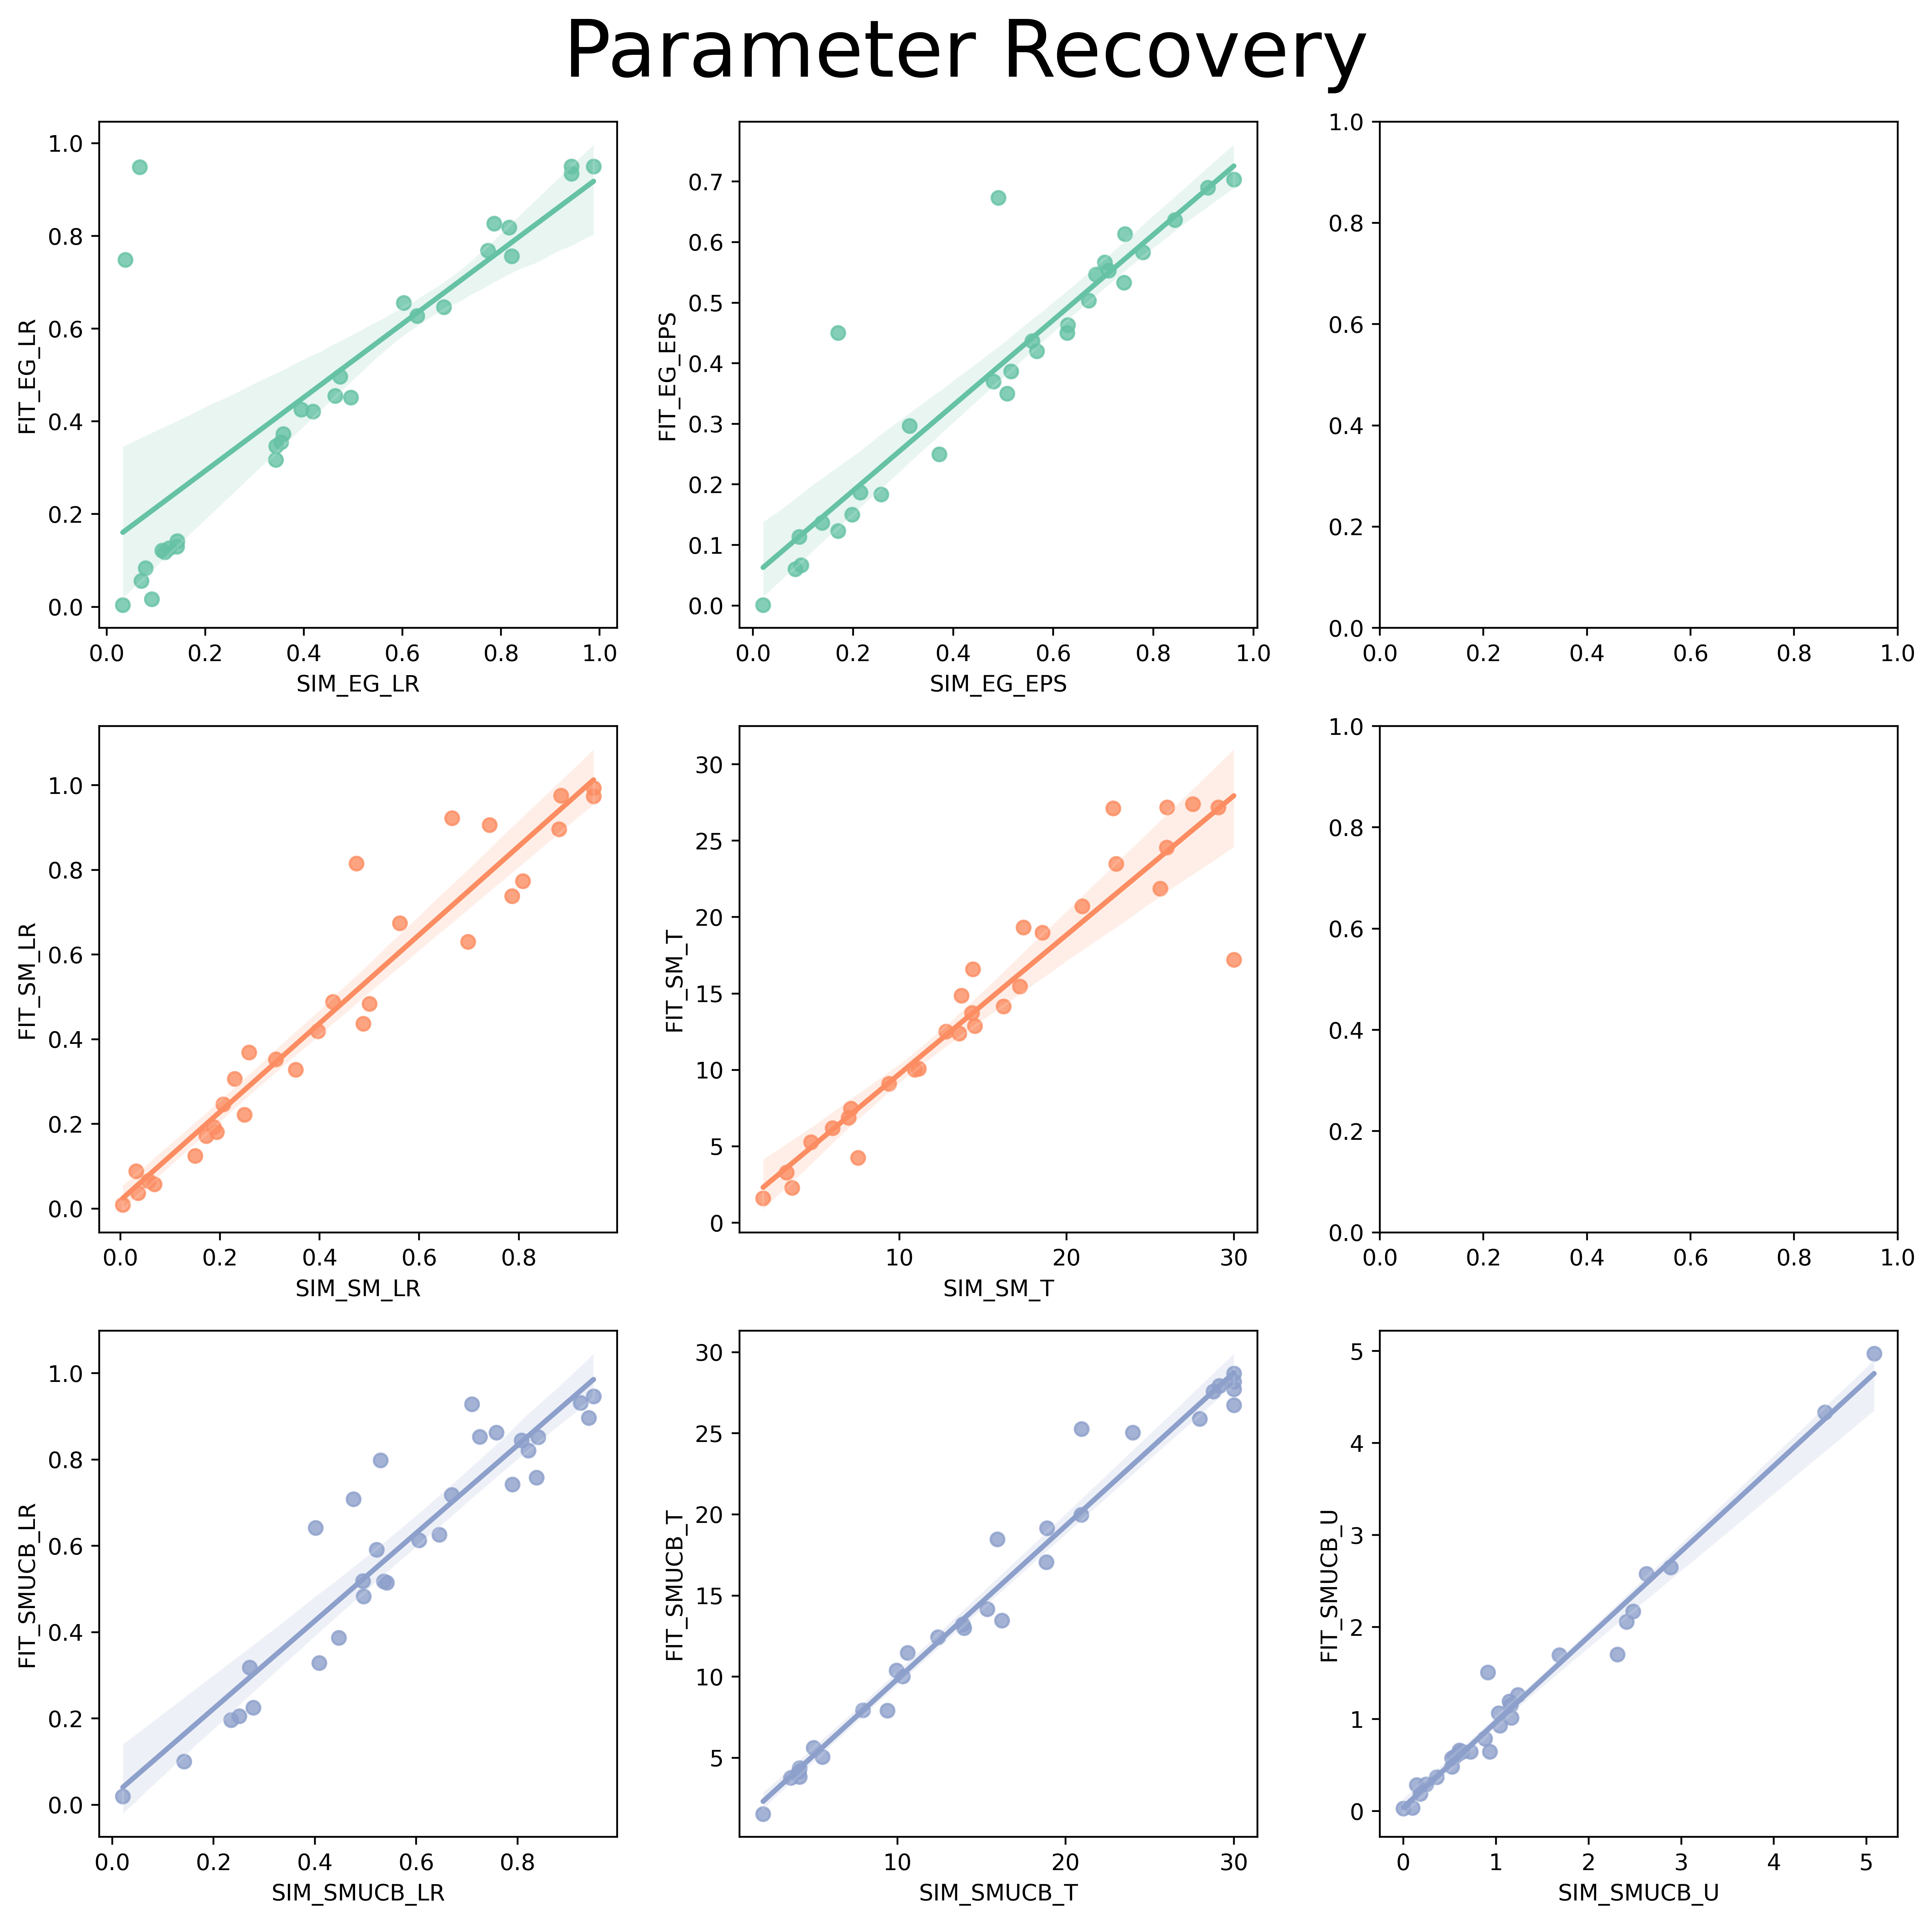

In [ ]:
# Set up colors
t = sns.color_palette("Set2")
colors = [t[0],t[0],t[1],t[1],t[2],t[2],t[2]]

# Actual Plot
fig, axs = plt.subplots(3,3, figsize=(12, 12), dpi=500)
fig.suptitle('Parameter Recovery', fontsize = 35)
sns.set(font_scale = 1)
sns.set_style("white")
sns.regplot(x='SIM_EG_LR', y='FIT_EG_LR',data=dfPR,color=t[0], ax=axs[0,0])
sns.regplot(x='SIM_EG_EPS', y='FIT_EG_EPS',data=dfPR,color=t[0], ax=axs[0,1])
sns.regplot(x='SIM_SM_LR', y='FIT_SM_LR',data=dfPR,color=t[1], ax=axs[1,0])
sns.regplot(x='SIM_SM_T', y='FIT_SM_T',data=dfPR,color=t[1], ax=axs[1,1])
sns.regplot(x='SIM_SMUCB_LR', y='FIT_SMUCB_LR',data=dfPR,color=t[2], ax=axs[2,0])
sns.regplot(x='SIM_SMUCB_T', y='FIT_SMUCB_T',data=dfPR,color=t[2], ax=axs[2,1])
sns.regplot(x='SIM_SMUCB_U', y='FIT_SMUCB_U',data=dfPR,color=t[2], ax=axs[2,2])
plt.tight_layout()
plt.show()

Let's also run the correlations

In [ ]:
# Loop for correlation values
for crCt in range(numParam):
    print(np.corrcoef(dfPR.iloc[:, crCt], dfPR.iloc[:, crCt+7])[0][1])

# Model Recovery

The next step is to check our model recovery. Here we can use the simulated choice and reward data from our parameter recovery step. Basically, we're just going to calculate negative log likelihood values using each model on the simulated data.

Note: this step is also very long, so I've uploaded a file with the model recovery values that I ran prior to this.

In [ ]:
# Set up Arrays
modTabAIC = np.zeros(shape=[numModels, numModels])
modTabBIC = np.zeros(shape=[numModels, numModels])

# Number of times to attempt fitting procedure
numFitMR = 5

for minLL in range(numModels):

    # Likelihood Fitting
    for pCt2 in tqdm(range(numSim)):

        # Sim Fit
        minFit = paramCreate(numFitMR)
        # Min arrays
        minArray_LL = np.zeros(shape=[numFitMR, 3])

        # Loop around the number of fitting attemps
        for fit in range(numFitMR):

            # eGreedy
            res_eG = minimize(LL_EG, minFit[fit, 0:2],
                            args=(rewModelPR[minLL, pCt2, :], choModelPR[minLL, pCt2, :], taskParam, qInit),
                            method="trust-constr", bounds=((.001, .95),(.001, .95))) #,(.01, 10)
            minArray_LL[fit, 0] = res_eG.fun

            # Softmax
            res_SM = minimize(LL_SM, minFit[fit, 2:4],
                            args=(rewModelPR[minLL, pCt2, :], choModelPR[minLL, pCt2, :], taskParam, qInit),
                            method="trust-constr", bounds=((.01, .95), (0.001, 30)))
            minArray_LL[fit, 1] = res_SM.fun

            # Softmax - Explore
            res_SMUCB = minimize(LL_SMUCB, minFit[fit, 4:7],
                            args=(rewModelPR[minLL, pCt2, :], choModelPR[minLL, pCt2, :], taskParam, qInit),
                            method="trust-constr", bounds=((.0001, .95), (0.001, 30), (.001, 10)))
            minArray_LL[fit, 2] = res_SMUCB.fun


        minArray_LL[minArray_LL == -0] = 10000
        ninf = float('-inf')
        minArray_LL[minArray_LL == ninf] = 10000


        # Transform into BIC/AIC
        paraArray = np.array([2,2,3])
        # AIC
        AICArray = 2*minArray_LL + 2*paraArray
        # BIC
        BICArray = 2*minArray_LL + paraArray*np.log(numTrials)

        # Find min model for each type
        # AIC
        loc = np.where(AICArray[:] == AICArray[:].min())
        # Update Table
        modTabAIC[minLL, loc[1][0]] += 1

        # BIC
        loc2 = np.where(BICArray[:] == BICArray[:].min())
        # Update Table
        modTabBIC[minLL, loc2[1][0]] += 1

AIC = (modTabAIC / numSim)*100
BIC = (modTabBIC / numSim)*100

### Plotting Model Recovery

Here again to save time, I've uploaded the model recovery. The two files are AIC values and BIC values for the percentage of people recovered by each model based on the simulated data from the parameter recovery step.

The rows are the model which generated the simulated data, while the columns are the best fitting model (from the simulated data).

The rows are set up as:
1. row 1 = eGreedy
2. row 2 = Softmax
3. row 3 = Softmax-UCB

The columns follow the same order.

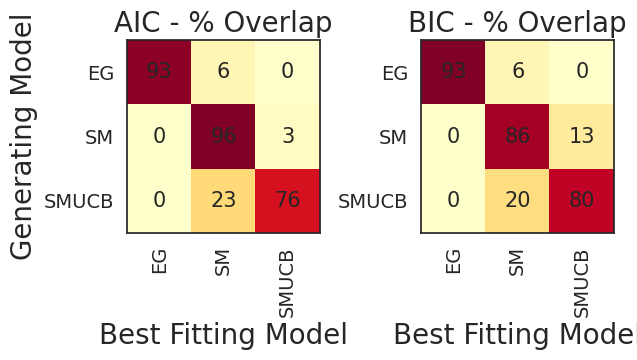

In [ ]:
# Load AIC Values
AIC = np.loadtxt("AIC_ModRec.csv", delimiter=",")

# Load BIC Values
BIC = np.loadtxt("BIC_ModRec.csv", delimiter=",")

# Set up labels for plotting
labs = ['EG', 'SM', 'SMUCB']

titles = ['AIC - % Overlap', 'BIC - % Overlap']

fig, axs = plt.subplots(1, 2)
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams.update({'font.size': 12})
for plC in range(2):
  plt.subplot(1, 2, plC+1)
  if plC == 1:
    data = AIC
  else:
    data = BIC
  data = data.astype(int)
  axs[plC].imshow(data, cmap ='YlOrRd', interpolation=None)
  for (j,i),label in np.ndenumerate(data):
      axs[plC].text(i,j,label,ha='center',va='center', fontsize = 15)
  axs[plC].set_yticks([0, 1, 2],labels=labs, fontsize = 14)
  axs[plC].set_xticks([0, 1, 2],labels=labs, fontsize = 14, rotation = 90)
  if plC == 0:
    axs[plC].set_ylabel('Generating Model',fontsize=20)
  axs[plC].set_xlabel('Best Fitting Model',fontsize=20)
  axs[plC].set_title(titles[plC],fontsize=20)
  axs[plC].grid(False)
plt.tight_layout()
plt.show()


# Fitting Models to Actual data

Here is some data from a series of participants who completed the task. The data files contains each person (n =30), and the option they choose and the reward they obtained on each trial. I've also included the underlying reward values of each of the arms from the non-stationary task the participants completed.

Participants only saw the reward of the arm they selected.

The data file is structured as:
1. PCode - the person (1 to 30)
2. Trial number - 1 to 300
3. The choice the person made (0 = arm 1, 1 = arm 2, etc.)
4. The reward they obtained for their choice
5. The reward of arm 1 (if they had made that choice)
6. The reward of arm 2 (if they had made that choice)
7. The reward of arm 3 (if they had made that choice)
8. The reward of arm 4 (if they had made that choice)

What we will do here is run our negative log likelihood scripts for each of the three models on the participants' choice and reward data, giving us three negative log likelihood values for each person. For each person, we then want to find the model that minimize the negative log likelihood, as we assume that model provides the best fit of the data and that people might be using that action selection approach (or at least, something similar).


In [ ]:
# Load CSV of the participants' data
fullData = np.loadtxt('fullData2.csv', delimiter = ',')

# Set number of times to do negLL fitting procedure
numFit = 1

# Generate empty parameter and negLL arrays
paraFit = np.zeros(shape = [numSim, numParam])
LLArray = np.zeros(shape= [numSim, numModels])

# Loop around data to find the best fitting model
for pCt in tqdm(range(numSim)):

    datFile = fullData[fullData[:, 0] == pCt+1]

    choices = datFile[:, 2]
    rewards = datFile[:, 3]

    # Sim Fit
    minFit = paramCreate(numFit)
    # Min arrays
    minArray_LL = np.zeros(shape=[numFit, numModels])
    minArray_Para = np.zeros(shape=[numFit, numParam])

    # Likelihood Fitting - loop around number of times we want to try it
    for llCt in range(numFit):

        # eGreedy
        res_eG = minimize(LL_EG, minFit[llCt, 0:2],
                        args=(rewards, choices, taskParam, qInit),
                        method="trust-constr", bounds=((.001, .95),(.001, .95)))
        minArray_LL[llCt, 0] = res_eG.fun
        minArray_Para[llCt, 0:2] = res_eG.x

        # Softmax
        res_SM = minimize(LL_SM, minFit[llCt, 2:4],
                        args=(rewards, choices, taskParam, qInit),
                        method="trust-constr", bounds=((0.001, .95), (.001, 30)))
        minArray_LL[llCt, 1] = res_SM.fun
        minArray_Para[llCt, 2:4] = res_SM.x

        # Softmax - Pers
        res_SMUCB = minimize(LL_SMUCB, minFit[llCt, 4:7],
                        args=(rewards, choices, taskParam, qInit),
                        method="trust-constr", bounds=((.0001, .95), (0.001, 30), (0.001, 10)))
        minArray_LL[llCt, 2] = res_SMUCB.fun
        minArray_Para[llCt, 4:7] = res_SMUCB.x

        minArray_LL[minArray_LL == -0] = 10000
        ninf = float('-inf')
        minArray_LL[minArray_LL == ninf] = 10000

    # eGreedy
    LLArray[pCt, 0] = min(minArray_LL[:, 0])
    loc = np.where(minArray_LL[:, 0] == minArray_LL[:, 0].min())
    paraFit[pCt, 0:2] = minArray_Para[loc[0][0], 0:2]

    # Softmax
    LLArray[pCt, 1] = min(minArray_LL[:, 1])
    loc = np.where(minArray_LL[:, 1] == minArray_LL[:, 1].min())
    paraFit[pCt, 2:4] = minArray_Para[loc[0][0], 2:4]

    # Softmax - Explore
    LLArray[pCt, 2] = min(minArray_LL[:, 2])
    loc = np.where(minArray_LL[:, 2] == minArray_LL[:, 2].min())
    paraFit[pCt, 4:7] = minArray_Para[loc[0][0], 4:7]

## Modify Negative Log Likelihood

We'll want to transform the negative log likelihood here into AIC values, and then further, into pseudo $R^2$ values. We'll also put it in a dataframe for plotting.

$$
\begin{equation}
R^2 = 1-
    \frac{\text{Model}_{AIC}}{\text{Baseline}_{AIC}}
\end{equation} \hspace{4.3cm} (7)
$$

We're going to calculate a baseline AIC value (to act as a baseline model). Basically it just says "what if people were making selections entirely by chance".

In [ ]:
# First we want to transform the raw negative log likelihood values into AIC Values
# The number of estimate parameters in each model
paraArray = np.array([2,2,3])

# Calculate the AIC value per the AIC formula
AICArray2 = 2*LLArray  + 2*paraArray

# This is the AIC value we would expect if people we're simply selected as chance
# It acts as a baseline model
AIC_Chance = 2*(-np.sum(np.log(.25)*numTrials)) + 2*0

# Next we can turn the AIC values into a pseudo R^2 value through using the Chance AIC values as a baseline
R2 = 1 - (AICArray2 / AIC_Chance)

# Find Best Fit
bestFitModels = np.argmax(R2, axis=1)

# Count Best Fit - needed for plotting below
eGVal = (bestFitModels == 0).sum()
smVal = (bestFitModels == 1).sum()
smUCBVal = (bestFitModels == 2).sum()

# Modify R^2 data from wide to long
R2_Long = R2.flatten(order='F')

# Create a dataframe for plotting
Comb_R2 = pd.DataFrame()

# Create List of model names
nameList = ['eGreedy'] *30
nameList2 = ['Softmax'] * 30
nameList3 = ['Softmax-UCB'] * 30

# Combine the List of models names
modelNames = nameList + nameList2 + nameList3

# Add the model names to the empty data frame
Comb_R2['Name']= modelNames

# Add the R^2 values to the empty data frame
Comb_R2['R2'] = R2_Long


## Plot $R^2$ Values

Then we can plot the pseudo $R^2$ values to see which model provides the best fit (up = better fit for a model) across all the participants. We will also add the number of participants (30 total) which the model provided the best fit below the $R^2$ values

In [ ]:
palette = sns.color_palette("Set2")

sns.set_style("white")
dx='variable'; dy='value'; ort="v"; sigma = .4;
plt.rcParams["figure.figsize"] = (7, 7)
sns.set(font_scale = 2)
sns.set_style("white")
ax = sns.stripplot(data=Comb_R2, x="Name", y="R2", hue="Name")
ax.axhline(0,linewidth=2,linestyle='--', color="black")
ax = sns.pointplot(data=Comb_R2, x="Name", y="R2", color="black", errorbar="ci", linestyle='none')
ax.set_ylim([-.25, 1])
ax.set(xlabel=' ', ylabel='$R^2$')
plt.text(-.4, -0.13, 'Best Fit: ' + str(eGVal), fontsize=18)
plt.text(.6, -0.13, 'Best Fit: ' + str(smVal), fontsize=18)
plt.text(1.6, -0.13, 'Best Fit: ' + str(smUCBVal), fontsize=18)
plt.show()

# Simulate Performance

The Last big step is to make sure the models can effectively simulate the humans data. We'll look at how often the models and the people selected the optimal arms and how often they switched (as a proxy for exploration).


To do this, we run the models through the same task the people, using the best fit parameter estimates. Assuming our parameter estimates are valid, and the model is doing what we think it is, then we should see relatively similar behaviour.

In [ ]:
# Set up Reward and Choice Arrays
rewModel = np.zeros(shape=[numModels+1, numSim, numTrials])
choModel = np.zeros(shape=[numModels, numSim, numTrials])

# Clear instance
tqdm._instances.clear()

# Generate Arrays
switchArray = np.zeros(shape=[numModels+1, numSim, numTrials])
optArray = np.zeros(shape=[numModels+1, numSim, numTrials])

# Array is set up:
maxArms = np.zeros(shape=[numSim, numTrials])

for pCt in tqdm(range(numSim)):

    datFile = fullData[fullData[:, 0] == pCt+1]

    # Find Reward Values
    rewardValues = datFile[:, 4:8]

    # Extract Participants choices and rewards
    humCho = datFile[:, 2]
    humRew = datFile[:, 3]

    # Find Max Arm Values
    maxArms[pCt, :] = np.argmax(rewardValues, axis=1)

    # eGreedy
    eGchoice = AS_EG(paraFit[pCt, 0:2], rewardValues, taskParam, qInit)
    choModel[0, pCt, :] = eGchoice[0]
    rewModel[0, pCt, :] =  eGchoice[1]

    # Softmax
    smChoice = AS_SM(paraFit[pCt, 2:4], rewardValues, taskParam, qInit)
    choModel[1, pCt, :] = smChoice[0]
    rewModel[1, pCt, :] =  smChoice[1]


    # Softmax - Explore
    smUCBChoice = AS_SMUCB(paraFit[pCt, 4:7], rewardValues, taskParam, qInit)
    choModel[2, pCt, :] = smUCBChoice[0]
    rewModel[2, pCt, :] =  smUCBChoice[1]


    # Compute Switching and Optimal Arm for the models
    for m in range(numModels):

        optArray[m, pCt, :] = choModel[m, pCt, :] == maxArms[pCt, :]


        for s in range(1, numTrials):

            if choModel[m,pCt, s-1] != choModel[m, pCt, s]:

                switchArray[m, pCt, s] = 1


    optArray[3, pCt, :] = humCho == maxArms[pCt, :]
    rewModel[3, pCt, :] = humRew

    for s in range(1, numTrials):

        if humCho[s-1] != humCho[s]:

            switchArray[3, pCt, s] = 1

## Plot of Performance

In [ ]:
# Compute Averages for optimal arm and switching
optArmAvg = np.average(optArray, axis = 1)*100
switchCount = (np.count_nonzero(switchArray == 1, axis =1) / (numSim))*100

# Set up title array
titleArray2 = ['eGreedy', 'Softmax', 'Softmax-UCB', 'Human']

#Plot Data
fig, axs = plt.subplots(2, 4, figsize=(16, 8), dpi=500)
fig.suptitle('Model Performance', fontsize=30)
for p in range(4):
    # Optimal Arm Choice
    axs[0, p].plot(optArmAvg[p, :], ls = '-',color = t[p])
    axs[0, p].set_xlabel("Trials", fontsize=16)
    axs[0, 0].set_ylabel('Optimal Arm (%)', fontsize=16)
    axs[0, p].set_ylim(0, 100)
    axs[0, p].set_title(titleArray2[p])
    axs[0, p].set_xticks([0, 100, 200, 300])
    # Q Values
    axs[1, p].plot(switchCount[p, :], ls = '-',color = t[p])
    axs[1, p].set_xlabel("Trials", fontsize=16)
    axs[1, 0].set_ylabel('Switching (%)', fontsize=16)
    axs[1, p].set_ylim(0, 100)
    axs[1, p].set_xticks([0, 100, 200, 300])
plt.tight_layout()
plt.show()

# References

1. Daw, N. D., O'doherty, J. P., Dayan, P., Seymour, B., & Dolan, R. J. (2006). Cortical substrates for exploratory decisions in humans. Nature, 441(7095), 876-879.
2. Speekenbrink, M., & Konstantinidis, E. (2015). Uncertainty and exploration in a restless bandit problem. Topics in cognitive science, 7(2), 351-367.
3. Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction. MIT press.
4. Wilson, R. C., & Collins, A. G. (2019). Ten simple rules for the computational modeling of behavioral data. Elife, 8, e49547.
5. Wilson, R. C., Geana, A., White, J. M., Ludvig, E. A., & Cohen, J. D. (2014). Humans use directed and random exploration to solve the explore–exploit dilemma. Journal of experimental psychology: General, 143(6), 2074.